In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import sys
sys.path.append('../')

In [ ]:
import gc
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from clearml import Task
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, ModelSummary
from torch import nn
from torch.utils.data import DataLoader
from transformers import GPT2Config, GPT2Model

from src.datasets import CausalLMDataset, CausalLMPredictionDataset, PaddingCollateFn
from src.models import SASRec
from src.modules import SeqRec, SeqRecWithSampling

from src.metrics import Evaluator
from src.postprocess import preds2recs
from src.preprocess import add_time_idx, filter_items, filter_users
from src.utils import extract_validation_history

from sklearn.model_selection import train_test_split

## Load data

In [3]:
data_path='../data/ml-1m.csv'
# data_path='../data/ml-20m.csv'

data = pd.read_csv(data_path)
data = add_time_idx(data)

train = data[data.time_idx_reversed >= 10]
test = data[data.time_idx_reversed < 10]

users_validation, users_test = train_test_split(
    test.user_id.unique(), test_size=0.5, random_state=42)
validation = test[test.user_id.isin(users_validation)]
test = test[test.user_id.isin(users_test)]

train = add_time_idx(train)
validation = add_time_idx(validation)
test = add_time_idx(test)

train2 = train[train.user_id.isin(users_validation)]
validation2 = validation[validation.time_idx == 0]
validation_full = pd.concat([train2, validation2])
validation_full = add_time_idx(validation_full)

## Dataloaders

In [4]:
MAX_LENGTH = 128
NUM_NEGATIVES = 1
FULL_NEGATIVE_SAMPLING = True

VALIDATION_SIZE = 2000
# VALIDATION_SIZE = None

BATCH_SIZE = 64
TEST_BATCH_SIZE = 256
NUM_WORKERS = 8

In [5]:
train_dataset = CausalLMDataset(train, max_length=MAX_LENGTH,
                                num_negatives=NUM_NEGATIVES,
                                full_negative_sampling=FULL_NEGATIVE_SAMPLING)

validation_users = validation_full.user_id.unique()
if VALIDATION_SIZE:
    np.random.seed(42)
    validation_users = np.random.choice(validation_users, size=VALIDATION_SIZE, replace=False)
eval_dataset = CausalLMPredictionDataset(validation_full[validation_full.user_id.isin(validation_users)],
                                         max_length=MAX_LENGTH, validation_mode=True)
collate_fn = PaddingCollateFn()

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())
eval_loader = DataLoader(
    eval_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())

## Model

In [6]:
SASREC_CONFIG = {
    'maxlen': 128,
    'hidden_units': 64,
    'num_blocks': 2,
    'num_heads': 1,
    'dropout_rate': 0.1,
}

In [7]:
model = SASRec(item_num=train.item_id.max(), **SASREC_CONFIG, add_head=False)

## Train

In [8]:
TRAINER_PARAMS = {
    'max_epochs': 100,
    'gpus': 1,
    'enable_checkpointing': True,
}

In [9]:
seqrec_module = SeqRecWithSampling(model, lr=0.001, predict_top_k=10, loss='bce')

early_stopping = EarlyStopping(monitor="val_ndcg", mode="max", patience=5, verbose=False)
model_summary = ModelSummary(max_depth=4)
checkpoint = ModelCheckpoint(save_top_k=1, monitor="val_ndcg", mode="max", save_weights_only=True)
callbacks=[early_stopping, model_summary, checkpoint]

trainer = pl.Trainer(callbacks=callbacks, **TRAINER_PARAMS)

trainer.fit(model=seqrec_module,
            train_dataloaders=train_loader,
            val_dataloaders=eval_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

   | Name                              | Type                            | Params
---------------------------------------------------------------------------------------
0  | model                             | SASRec                          | 311 K 
1  | model.item_emb                    | Embedding                       | 252 K 
2  | model.pos_emb                     | Embedding                       | 8.2 K 
3  | model.emb_dropout                 | Dropout                         | 0     
4  | model.attention_layernorms        | ModuleList                      | 256   
5  | model.attention_layernorms.0      | LayerNorm     

Epoch 0:  92%|███████████████████████████████████████████████▉    | 95/103 [00:03<00:00, 24.91it/s, loss=0.497, v_num=8]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.18it/s]
Epoch 0: 100%|█| 103/103 [00:11<00:00,  8.77it/s, loss=0.497, v_num=8, val_ndcg=0.0282, val_hit_rate=0.053, val_mrr=0.02
Epoch 1:  92%|▉| 95/103 [00:03<00:00, 29.94it/s, loss=0.436, v_num=8, val_ndcg=0.0282, val_hit_rate=0.053, val_mrr=0.020
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|███████▌                                                    | 1/8 [00:00<00:06,  1.01it/s]
Epoch 1:  93%|▉| 96/103 [00:04<00:00, 19.58it/s, loss=0.436, v_num=8, val_ndcg=0.0282, val_hit_rate=0.053, val_mrr=0.020
Validation DataLoader 0:  25%|███████████████                                             | 2/8 [00:01<00:05,  1.16it/s]
Epoch 1:  94%|▉| 97/103 [00:05<00:00, 17.09it/s, loss=0.436, v_num=8, val_ndcg=0.0282, val_

In [ ]:
seqrec_module.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])

<Axes: xlabel='epoch'>

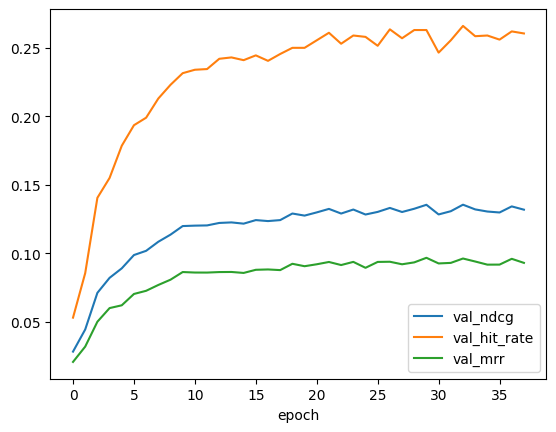

In [11]:
history = extract_validation_history(trainer.logger.experiment.log_dir)
history.drop(columns=['step', 'time']).plot(x="epoch")

In [12]:
predict_dataset = CausalLMPredictionDataset(train, max_length=MAX_LENGTH)

predict_loader = DataLoader(
    predict_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=PaddingCollateFn())

preds = trainer.predict(model=seqrec_module, dataloaders=predict_loader)

recs = preds2recs(preds)
print(recs.shape)
recs.head()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 24/24 [00:03<00:00, -20.00it/s]
(60400, 3)


,user_id,item_id,prediction
0,1,364,9.022525
1,1,1282,7.166266
2,1,2078,6.979857
3,1,2096,6.917939
4,1,596,6.866875


## Predict validation

In [13]:
val_users = validation.user_id.unique()
test_users = test.user_id.unique()

train_for_val = train[train.user_id.isin(val_users)]
train_for_test = train[train.user_id.isin(test_users)]

predict_for_val_dataset = CausalLMPredictionDataset(train_for_val, max_length=MAX_LENGTH)
predict_for_val_loader = DataLoader(
    predict_for_val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=PaddingCollateFn())

predict_for_test_dataset = CausalLMPredictionDataset(train_for_test, max_length=MAX_LENGTH)
predict_for_test_loader = DataLoader(
    predict_for_test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=PaddingCollateFn())

In [14]:
val_preds = trainer.predict(model=seqrec_module, dataloaders=predict_for_val_loader)
val_recs = preds2recs(val_preds)
print(val_recs.shape)
val_recs.head()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 12/12 [00:01<00:00, -47.88it/s]
(30200, 3)


,user_id,item_id,prediction
0,2,1320,7.530209
1,2,1917,7.515641
2,2,292,6.832163
3,2,1037,6.790141
4,2,1876,6.720715


In [15]:
%%time
evaluator = Evaluator(col_time_idx='time_idx')
val_metrics = pd.Series(evaluator.compute_metrics(validation, val_recs, train))
val_metrics

CPU times: user 1.87 s, sys: 543 ms, total: 2.42 s
Wall time: 2.41 s


map@10          0.073793
ndcg@10         0.156670
recall@10       0.144669
coverage@10     0.542432
entropy@10     10.030864
novelty@10     10.454380
dtype: float64

In [16]:
evaluator.compute_metrics_by_time_idx(validation, val_recs)

,map@10,ndcg@10,recall@10
0,0.094195,0.133206,0.262252
1,0.085919,0.119032,0.228477
2,0.061846,0.088687,0.178477
3,0.054738,0.080244,0.165232
4,0.042103,0.063695,0.136093
5,0.041833,0.060897,0.124503
6,0.034076,0.050511,0.105960
7,0.028695,0.043531,0.093709
8,0.026508,0.039514,0.083444
9,0.021748,0.032524,0.068543


In [17]:
evaluator.compute_metrics_by_time_idx(validation, val_recs, top_k_gt=True)

,map@10,ndcg@10,recall@10
0,0.094195,0.133206,0.262252
1,0.099594,0.154659,0.245364
2,0.095447,0.159989,0.223068
3,0.093218,0.164416,0.208609
4,0.088915,0.164446,0.194106
5,0.086435,0.165149,0.182506
6,0.083526,0.163901,0.171570
7,0.080228,0.161833,0.161838
8,0.077157,0.159670,0.153127
9,0.073793,0.156670,0.144669


## Predict test

In [18]:
preds_test = trainer.predict(model=seqrec_module, dataloaders=predict_for_test_loader)

test_recs = preds2recs(preds_test)
print(test_recs.shape)
test_recs.head()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 12/12 [00:01<00:00, -45.58it/s]
(30200, 3)


,user_id,item_id,prediction
0,1,364,9.022525
1,1,1282,7.166266
2,1,2078,6.979857
3,1,2096,6.917939
4,1,596,6.866875


In [19]:
%%time
test_metrics = pd.Series(evaluator.compute_metrics(test, test_recs, train))
test_metrics

CPU times: user 1.9 s, sys: 531 ms, total: 2.43 s
Wall time: 2.43 s


map@10          0.070418
ndcg@10         0.151258
recall@10       0.140728
coverage@10     0.545405
entropy@10     10.048443
novelty@10     10.487486
dtype: float64

In [20]:
evaluator.compute_metrics_by_time_idx(test, test_recs, )

,map@10,ndcg@10,recall@10
0,0.102923,0.141118,0.267881
1,0.071596,0.103955,0.212583
2,0.063775,0.091989,0.185762
3,0.053402,0.078875,0.164238
4,0.046029,0.068126,0.141391
5,0.037219,0.056598,0.121523
6,0.030341,0.046281,0.100000
7,0.025700,0.037893,0.078808
8,0.023073,0.034594,0.073179
9,0.017727,0.027820,0.061921


In [21]:
evaluator.compute_metrics_by_time_idx(test, test_recs, top_k_gt=True) 

,map@10,ndcg@10,recall@10
0,0.102923,0.141118,0.267881
1,0.094878,0.150266,0.240232
2,0.092988,0.158176,0.222075
3,0.090657,0.162373,0.207616
4,0.088419,0.164175,0.194371
5,0.085111,0.163605,0.182230
6,0.081353,0.161336,0.170482
7,0.077384,0.158047,0.159023
8,0.073942,0.154996,0.149485
9,0.070418,0.151258,0.140728
